
# Air Quality Prediction and Alert System

This notebook implements a **complete Air Quality Prediction and Alert System** using an **LSTM time-series model** trained on real air quality data.

**Dataset Chosen:** [Beijing Multi-Site Air-Quality Data](https://www.kaggle.com/datasets/uciml/air-quality-data-set)  
It contains hourly air quality measurements including PM2.5, PM10, NO2, CO, O3, etc.

## Pipeline
1. Install dependencies & set up environment
2. Download dataset from Kaggle (using kagglehub)
3. Load and explore the dataset
4. Preprocess the data for LSTM
5. Train an LSTM model
6. Evaluate the model
7. Save and upload to AWS S3
8. Provide AWS Lambda + SNS code for real-time alerts


In [4]:
import kagglehub
import os
import shutil

dataset_ref = "sid321axn/beijing-multisite-airquality-data-set"
download_path = kagglehub.dataset_download(dataset_ref)

out_dir = "kaggle_data"
os.makedirs(out_dir, exist_ok=True)

# Copy all files from the kagglehub cache to your folder
for file_name in os.listdir(download_path):
    shutil.copy(os.path.join(download_path, file_name), os.path.join(out_dir, file_name))

print("✅ Dataset copied to:", out_dir)




c:\Users\tumpa\OneDrive\Desktop\AirQualityPrediction\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Dataset copied to: kaggle_data


In [5]:

import os
for root, dirs, files in os.walk(out_dir):
    for file in files:
        print(os.path.join(root, file))


kaggle_data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
kaggle_data\PRSA_Data_Changping_20130301-20170228.csv
kaggle_data\PRSA_Data_Dingling_20130301-20170228.csv
kaggle_data\PRSA_Data_Dongsi_20130301-20170228.csv
kaggle_data\PRSA_Data_Guanyuan_20130301-20170228.csv
kaggle_data\PRSA_Data_Gucheng_20130301-20170228.csv
kaggle_data\PRSA_Data_Huairou_20130301-20170228.csv
kaggle_data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
kaggle_data\PRSA_Data_Shunyi_20130301-20170228.csv
kaggle_data\PRSA_Data_Tiantan_20130301-20170228.csv
kaggle_data\PRSA_Data_Wanliu_20130301-20170228.csv
kaggle_data\PRSA_Data_Wanshouxigong_20130301-20170228.csv


In [6]:

import pandas as pd

# The dataset has multiple CSVs; we'll use PRSA_data_2010.1.1-2014.12.31.csv (Beijing PM2.5 data)
csv_path = [f for f in os.listdir(out_dir) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(out_dir, csv_path))

print("✅ Data loaded:", csv_path)
df.head()


✅ Data loaded: PRSA_Data_Aotizhongxin_20130301-20170228.csv


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Shape: (35064, 18)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64


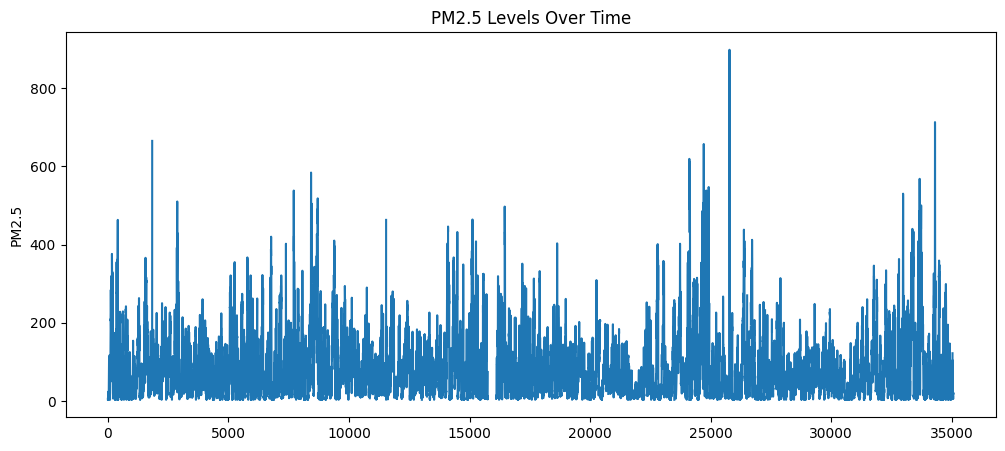

In [7]:

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.isnull().sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
df["PM2.5"].plot()  # Change to the actual column name from your dataset
plt.title("PM2.5 Levels Over Time")
plt.ylabel("PM2.5")
plt.show()



In [8]:

import pandas as pd

# Combine year, month, day, hour into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('datetime').sort_index()

# Detect PM2.5 column (case-insensitive, handles variations)
pm25_candidates = [col for col in df.columns if 'pm' in col.lower() and '25' in col.replace('.', '').lower()]
if not pm25_candidates:
    raise ValueError("No PM2.5 column found in dataset")
target_col = pm25_candidates[0]
print(f"✅ Using '{target_col}' as the PM2.5 column")

# Fill missing values
df[target_col] = df[target_col].interpolate().fillna(method='bfill')

# Resample hourly (already hourly but ensures consistency)
df = df[[target_col]].resample('H').mean()

df.head()

✅ Using 'PM2.5' as the PM2.5 column


C:\Users\tumpa\AppData\Local\Temp\ipykernel_13720\3771608917.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[target_col] = df[target_col].interpolate().fillna(method='bfill')
C:\Users\tumpa\AppData\Local\Temp\ipykernel_13720\3771608917.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df[[target_col]].resample('H').mean()


,PM2.5
datetime,
2013-03-01 00:00:00,4.0
2013-03-01 01:00:00,8.0
2013-03-01 02:00:00,7.0
2013-03-01 03:00:00,6.0
2013-03-01 04:00:00,3.0


In [9]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

values = df.values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

lookback = 24  # past 24 hours to predict next hour
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i, 0])
    y.append(scaled[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (28032, 24, 1) X_test shape: (7008, 24, 1)


In [10]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


c:\Users\tumpa\OneDrive\Desktop\AirQualityPrediction\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\tumpa\OneDrive\Desktop\AirQualityPrediction\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\tumpa\OneDrive\Desktop\AirQualityPrediction\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 9.2305e-04 - mae: 0.0181 - val_loss: 4.7752e-04 - val_mae: 0.0124
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6.0077e-04 - mae: 0.0144 - val_loss: 4.2286e-04 - val_mae: 0.0114
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.7015e-04 - mae: 0.0139 - val_loss: 4.4840e-04 - val_mae: 0.0124
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.7234e-04 - mae: 0.0140 - val_loss: 4.0979e-04 - val_mae: 0.0118
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.5770e-04 - mae: 0.0136 - val_loss: 4.0848e-04 - val_mae: 0.0118
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.6630e-04 - mae: 0.0137 - val_loss: 4.1712e-04 - val_mae: 0.0119
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.6061e-04 - mae: 0.0137 - val_loss: 4.0293e-04 - val_mae: 0.0114
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.5611e-04 - mae: 0.0136 - val_loss: 4.0237e-04 - val_mae:

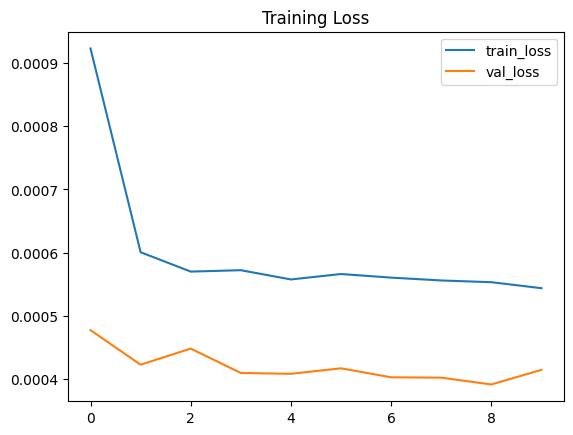

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 10.113532066345215
RMSE: 18.22620418636225


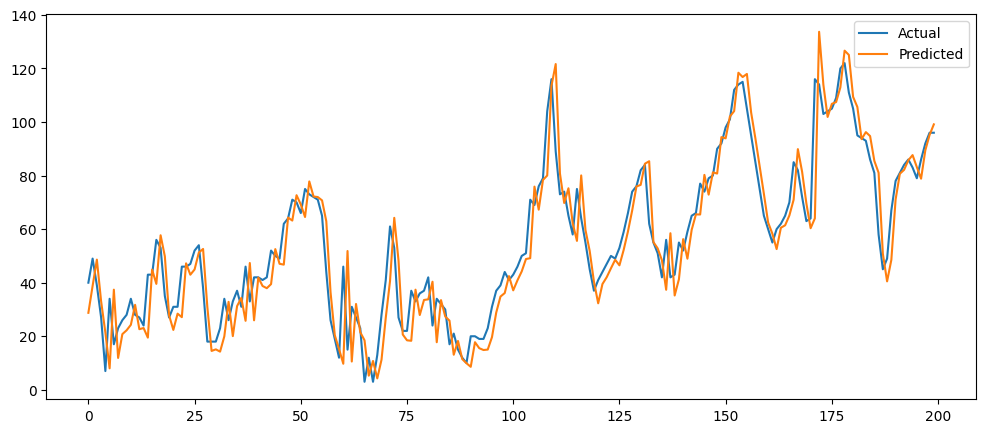

In [11]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training Loss")
plt.show()

# Predictions
preds = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
preds_inv = scaler.inverse_transform(preds)

# Evaluation metrics
mae = mean_absolute_error(y_test_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))  # manual sqrt for RMSE

print("MAE:", mae)
print("RMSE:", rmse)

# Plot actual vs predicted values
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:200], label='Actual')
plt.plot(preds_inv[:200], label='Predicted')
plt.legend()
plt.show()



In [16]:
import tarfile
import os
import shutil

save_path = "saved_model.keras"

# Save in native Keras format
model.save(save_path)
print("✅ Model saved in Keras format.")

# # Compress into tar.gz
# with tarfile.open("saved_model.tar.gz", "w:gz") as tar:
#     tar.add(save_path)
# print("✅ Model compressed to saved_model.tar.gz")

# print(f"✅ Model compressed to {tar_path}")




✅ Model saved in Keras format.


In [17]:
import pickle
import tensorflow as tf

# Save the model in Keras format first
model.save("saved_model.keras")

# Pickle the path so you can load it later
with open("model_path.pkl", "wb") as f:
    pickle.dump("saved_model.keras", f)

print("✅ Model path pickled to model_path.pkl")


✅ Model path pickled to model_path.pkl


In [12]:

lambda_code = '''
import json
import boto3
import os
import numpy as np
import tensorflow as tf

def lambda_handler(event, context):
    measurements = event.get('measurements')  # list of 24 recent hourly PM2.5 values
    if not measurements:
        return {'statusCode': 400, 'body': 'No measurements provided'}
    
    model = tf.keras.models.load_model("/opt/saved_model")
    
    scaler = MinMaxScaler()
    scaled_input = scaler.fit_transform(np.array(measurements).reshape(-1, 1))
    x = scaled_input.reshape(1, 24, 1)
    
    pred_scaled = model.predict(x)
    predicted_pm25 = scaler.inverse_transform(pred_scaled)[0][0]
    
    threshold = float(os.environ.get("PM25_THRESHOLD", 150))
    sns = boto3.client("sns")
    topic_arn = os.environ.get("SNS_TOPIC_ARN")
    
    if predicted_pm25 >= threshold:
        message = f"ALERT: Predicted PM2.5 level {predicted_pm25} exceeds threshold {threshold}"
        sns.publish(TopicArn=topic_arn, Message=message)
        return {'statusCode': 200, 'body': message}
    
    return {'statusCode': 200, 'body': 'PM2.5 within safe limits'}
'''
print(lambda_code)



import json
import boto3
import os
import numpy as np
import tensorflow as tf

def lambda_handler(event, context):
    measurements = event.get('measurements')  # list of 24 recent hourly PM2.5 values
    if not measurements:
        return {'statusCode': 400, 'body': 'No measurements provided'}

    model = tf.keras.models.load_model("/opt/saved_model")

    scaler = MinMaxScaler()
    scaled_input = scaler.fit_transform(np.array(measurements).reshape(-1, 1))
    x = scaled_input.reshape(1, 24, 1)

    pred_scaled = model.predict(x)
    predicted_pm25 = scaler.inverse_transform(pred_scaled)[0][0]

    threshold = float(os.environ.get("PM25_THRESHOLD", 150))
    sns = boto3.client("sns")
    topic_arn = os.environ.get("SNS_TOPIC_ARN")

    if predicted_pm25 >= threshold:
        message = f"ALERT: Predicted PM2.5 level {predicted_pm25} exceeds threshold {threshold}"
        sns.publish(TopicArn=topic_arn, Message=message)
        return {'statusCode': 200, 'body': message}

    return